**RNA statistics in the PDB**

This notebook provides tools to query the PDBe Search API and analyze entries containing RNA in the PDB.  

The notebook highlights:

- The diversity of RNA structures in the PDB.  

- Trends in structure determination methods.  

- Insights into RNA composition across deposited entries.

- Insight into modified RNA residues. 

Dependencies

- requests  
- pandas
- numpy 
- seaborn
- matplotlib
- solrq


**Setup Environment**

Import required libraries and define the PDBe API search endpoint.

In [57]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from solrq import Q  # For query formatting
import collections
# Define the PDBe API URL
search_url = "https://www.ebi.ac.uk/pdbe/search/pdb/select?"
# Set seaborn style
sns.set(style="whitegrid")

**API Helper Functions**-

- make_request() → Sends search queries to the PDBe API.  

- format_search_terms() → Formats user queries and filters.  

- run_search() / run_grouped_search() → Runs searches and retrieves results (optionally grouped by pdb_id).  

- change_lists_to_strings() → Cleans up results by converting list fields into comma-separated strings.  

- pandas_dataset() → Converts results into a Pandas DataFrame.  

- pandas_count() → Counts unique values in a chosen column.  

- display_table() → Displays a preview of results in Jupyter. 

In [58]:
def make_request(search_dict, number_of_rows=10, group_pdb=False):
    """
    Makes a GET request to the PDBe API.

    :param dict search_dict: The terms used for searching.
    :param number_of_rows: Number of rows to return (default 10).
    :param group_pdb: Whether to group by pdb_id (default False).
    :return dict: JSON response from the API.
    """
    search_dict.setdefault('rows', number_of_rows)
    search_dict['wt'] = 'json'

    if group_pdb:
        search_dict.update({
            'group': 'true',
            'group.field': 'pdb_id',
            'group.ngroups': 'true'
        })

    response = requests.post(search_url, data=search_dict)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"[No data retrieved - {response.status_code}] {response.text}")
        return {}
    
def format_search_terms(search_terms, filter_terms=None):
    """
    Format search terms into the query format for the API.

    :param search_terms: The search query.
    :param filter_terms: Additional fields to filter by (default None).
    :return dict: The formatted search dictionary.
    """
    return {'q': str(search_terms), 'fl': ','.join(filter_terms) if filter_terms else None}

def run_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=False):
    """
    Run a search with the given search terms and filters.

    :param search_terms: The search query.
    :param filter_terms: Fields to filter by (default None).
    :param number_of_rows: Number of rows to return (default 100).
    :param group_pdb: Whether to group by pdb_id (default False).
    :return list: The search results.
    """
    search_term = format_search_terms(search_terms, filter_terms)
    response = make_request(search_term, number_of_rows, group_pdb)

    return response.get('response', {}).get('docs', [])
def run_grouped_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=True):
    """
    Run a grouped search with the given search terms and filters.

    :param search_terms: The search query.
    :param filter_terms: Fields to filter by (default None).
    :param number_of_rows: Number of rows to return (default 100).
    :param group_pdb: Whether to group by pdb_id (default True).
    :return list: The grouped search results.
    """
    search_term = format_search_terms(search_terms, filter_terms)
    response = make_request(search_term, number_of_rows, group_pdb)

    grouped_results = []
    preresults = response.get('grouped', {}).get('pdb_id', {}).get('groups', [])
    for group in preresults:
        docs = group.get('doclist', {}).get('docs', [])
        grouped_results.extend(docs)

    return grouped_results
def change_lists_to_strings(results):
    """
    Converts lists within results to sorted, unique comma-separated strings.

    :param results: The list of results to process.
    :return list: Processed list of results.
    """
    for row in results:
        for key, value in row.items():
            if isinstance(value, list):
                row[key] = ','.join(sorted(set(map(str, value))))
    return results
def pandas_dataset(results):
    """
    Converts search results into a Pandas DataFrame.

    :param results: The search results to convert.
    :return DataFrame: The resulting Pandas DataFrame.
    """
    results = change_lists_to_strings(results)
    return pd.DataFrame(results)

def pandas_count(results, column_to_group_by):
    """
    Counts unique values in a specified column.

    :param results: The search results.
    :param column_to_group_by: The column to group by.
    :return Series: A Pandas Series with counts of unique values.
    """
    df = pandas_dataset(results)
    return df.groupby(column_to_group_by)['pdb_id'].nunique().sort_values(ascending=False)

def display_table(df, top_n=10):
    """
    Display a Pandas DataFrame as a table.

    :param df: The DataFrame to display.
    :param top_n: The number of rows to show (default 10).
    """
    display(df.head(top_n))

print("All ready, move to next code")

All ready, move to next code


**Query RNA Structures**

Run searches against the PDBe API to retrieve RNA-related entries.  
You can choose filters (e.g., resolution, polymer type, release year).

In [42]:
search_terms = Q(status="REL", molecule_type='RNA')
filter_terms = ['pdb_id', 'title', 'release_year', 'rfam','organism_scientific_name',
                'experimental_method',
                'journal',
                'assembly_composition',
                'processing_site', 'entity_weight', 'interacting_ligands', 'compound_name', 'modified_compound_id','molecule_name']
results = run_grouped_search(search_terms, filter_terms, number_of_rows=20000, group_pdb=True)

df_results = pandas_dataset(results)
display_table(df_results, top_n=20)

,assembly_composition,entity_weight,experimental_method,journal,molecule_name,organism_scientific_name,pdb_id,processing_site,release_year,rfam,title,compound_name,interacting_ligands,modified_compound_id
0,RNA structure,55405.130,Electron Microscopy,Nat Methods,RNA (171-MER),Fusobacterium nucleatum,6wll,RCSB,2020,RF00504 : Glycine riboswitch aptamer,"Apo F. nucleatum glycine riboswitch models, 10...",NaN,NaN,NaN
1,RNA structure,36229.492,X-ray diffraction,J Struct Biol X,RNA (112-MER),Fusobacterium nucleatum,6wjr,RCSB,2020,RF00050 : FMN riboswitch aptamer (RFN element),Apo structure of the FMN riboswitch aptamer do...,"MG : magnesium,MG : magnesium(+2) cation,SO4 :...","MG : MAGNESIUM ION,SO4 : SULFATE ION",NaN
2,RNA/protein complex,37254.855,Electron Microscopy,Cell Res,U5snRNA,Homo sapiens,6id1,PDBJ,2019,RF00020 : U5 spliceosomal RNA,Cryo-EM structure of a human intron lariat spl...,"GTP : [[(2R,3S,4R,5R)-5-(2-azanyl-6-oxidanylid...",NaN,SEP
3,RNA structure,3235.033,X-ray diffraction,Nucleic Acids Res,RNA (5'-R(*CP*CP*GP*GP*(LV2)P*GP*CP*CP*GP*G)-3'),synthetic construct,6wy3,RCSB,2020,NaN,"Crystal structure of RNA-10mer: CCGG(N4,N4-dim...","LV2 : [(2~{R},3~{S},4~{R},5~{R})-5-[4-(dimethy...",NaN,LV2
4,RNA structure,109298.710,Electron Microscopy,Nat Methods,RNA (338-MER),synthetic construct,6wlo,RCSB,2020,NaN,"hc16 ligase models, 11.0 Angstrom resolution",NaN,NaN,NaN
5,RNA/protein complex,941306.200,Electron Microscopy,Proc Natl Acad Sci U S A,23S ribosomal RNA,Escherichia coli,6i0y,PDBE,2018,RF02541 : Bacterial large subunit ribosomal RNA,TnaC-stalled ribosome complex with the titin I...,"MG : magnesium,MG : magnesium(+2) cation,TRP :...","MG : MAGNESIUM ION,TRP : TRYPTOPHAN",NaN
6,DNA/RNA/protein complex,30477.963,X-ray diffraction,Nat Commun,RNA (94-MER),Acidothermus cellulolyticus 11B,6wbr,RCSB,2020,NaN,Crystal structure of AceCas9 bound with guide ...,"GTP : [[(2R,3S,4R,5R)-5-(2-azanyl-6-oxidanylid...",NaN,GTP
7,RNA/protein complex,501090.780,Electron Microscopy,Sci Rep,16S ribosomal RNA,Enterococcus faecalis OG1RF,6w6p,RCSB,2020,RF00177 : Bacterial small subunit ribosomal RNA,MultiBody Refinement of 70S Ribosome from Ente...,"ZN : zinc,ZN : zinc(+2) cation",NaN,NaN
8,RNA/protein complex,948035.600,X-ray diffraction,Nat Chem Biol,23S ribosomal RNA,Thermus thermophilus HB8,6xhw,RCSB,2020,RF02541 : Bacterial large subunit ribosomal RNA,Crystal structure of the A2058-unmethylated Th...,"0TD : (2R,3S)-2-azanyl-3-methylsulfanyl-butane...","K : POTASSIUM ION,MG : MAGNESIUM ION","0TD,2MA,2MG,2MU,31H,4OC,4SU,5MC,5MU,7MG,F3N,M2..."
9,RNA/protein complex,498725.400,Electron Microscopy,Nature,16S ribosomal RNA,Escherichia coli,6wdh,RCSB,2020,RF00177 : Bacterial small subunit ribosomal RNA,Cryo-EM of elongating ribosome with EF-Tu*GTP ...,FME : (2S)-2-formamido-4-methylsulfanyl-butano...,NaN,NaN


**Data Preparation**

Convert results into Pandas DataFrames and clean fields (e.g., lists → comma-separated strings).

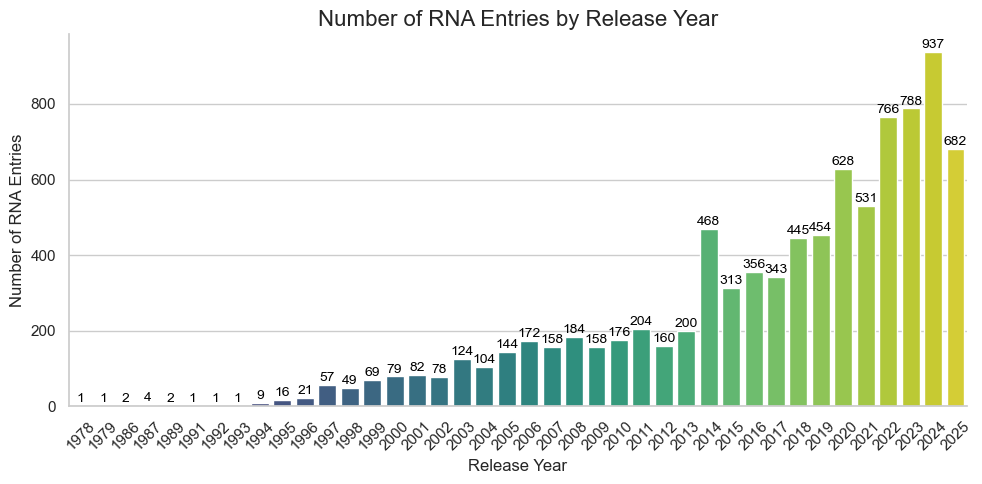

In [12]:
results = run_grouped_search(search_terms, filter_terms, number_of_rows=20000, group_pdb=True)

df_results = pandas_dataset(results)

df_yearly_counts = df_results.groupby('release_year').size().reset_index(name='count')

df_yearly_counts = df_yearly_counts.sort_values(by='release_year', ascending=True)

#display_table(df_results, top_n=20)

plt.figure(figsize=(10, 5))
ax = sns.barplot(x='release_year', y='count', data=df_yearly_counts, palette='viridis')

plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Number of RNA Entries', fontsize=12)
plt.title('Number of RNA Entries by Release Year', fontsize=16)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
sns.despine()  # Remove top and right axes for cleaner view
plt.tight_layout()
plt.show()

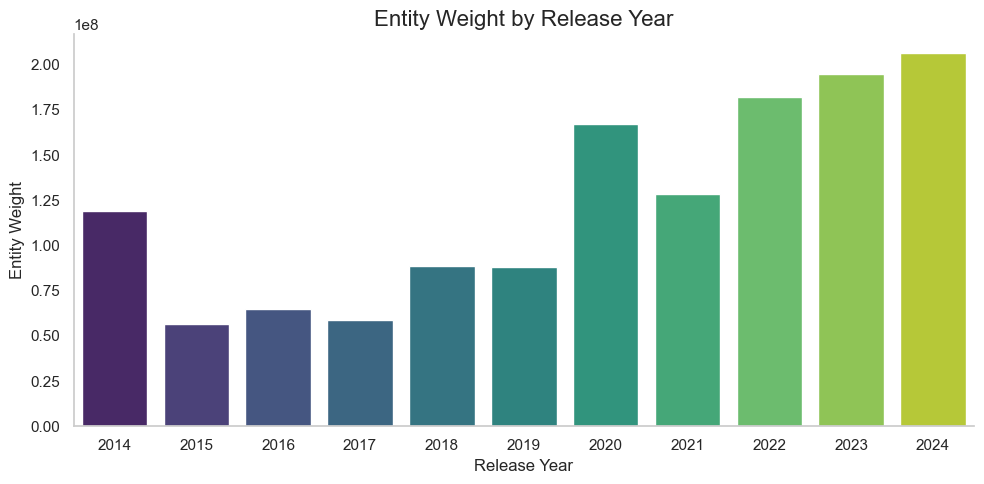

In [13]:
df_results['release_year'] = pd.to_numeric(df_results['release_year'], errors='coerce')
#display_table(df_results, top_n=20)

#df_results['release_year'] = df_results['release_year'].dt.year
df_results['entity_weight'] = pd.to_numeric(df_results['entity_weight'], errors='coerce')

df_yearly_entity_weight = df_results.groupby('release_year')['entity_weight'].sum().reset_index()
#display_table(df_yearly_entity_weight, top_n=20)
df_selected_years = df_yearly_entity_weight[(df_yearly_entity_weight['release_year'] >= 2014) & 
                                            (df_yearly_entity_weight['release_year'] <= 2024)]
#display_table(df_selected_years)

plt.figure(figsize=(10, 5))
ax = sns.barplot(x='release_year', y='entity_weight', data=df_selected_years, palette='viridis')

plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Entity Weight', fontsize=12)
plt.title('Entity Weight by Release Year', fontsize=16)

plt.grid(False)
sns.despine()
plt.tight_layout()


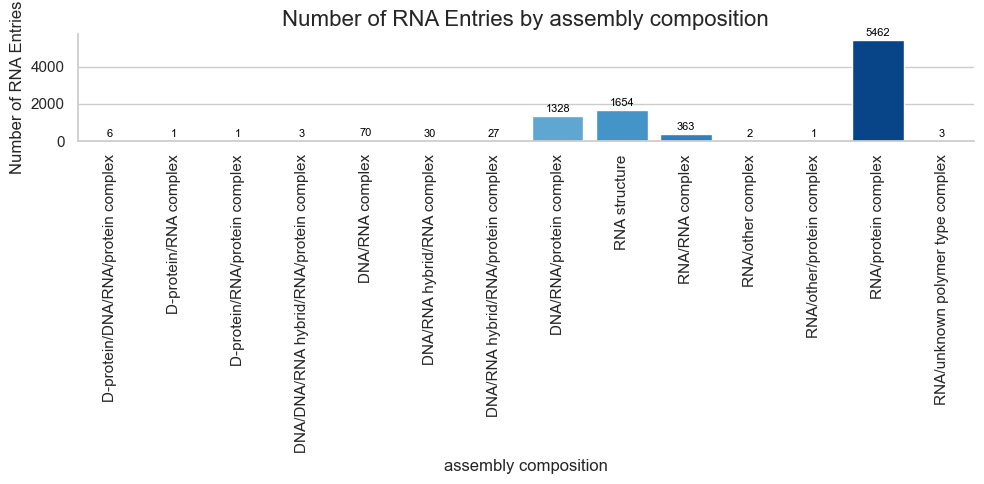

In [17]:
df_yearly_counts = df_results.groupby('assembly_composition').size().reset_index(name='count')

df_yearly_counts = df_yearly_counts.sort_values(by='assembly_composition', ascending=True)

#display_table(df_results, top_n=20)

# Convert 'assembly_composition' to categorical codes
df_yearly_counts['assembly_composition_code'] = pd.Categorical(df_yearly_counts['assembly_composition']).codes

norm = plt.Normalize(df_yearly_counts['assembly_composition_code'].min(), df_yearly_counts['assembly_composition_code'].max())
cmap = cm.Blues

df_yearly_counts['color'] = [cmap(norm(code)) for code in df_yearly_counts['assembly_composition_code']]

plt.figure(figsize=(10, 5))
ax = sns.barplot(x='assembly_composition', y='count', data=df_yearly_counts, palette='viridis')

for i, p in enumerate(ax.patches):
    p.set_facecolor(df_yearly_counts['color'].iloc[i])

plt.xlabel('assembly composition', fontsize=12)
plt.ylabel('Number of RNA Entries', fontsize=12)
plt.title('Number of RNA Entries by assembly composition', fontsize=16)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=8, color='black', 
                xytext=(0, 5), textcoords='offset points')

plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
sns.despine()  # Remove top and right axes for cleaner view
plt.tight_layout()
plt.show()

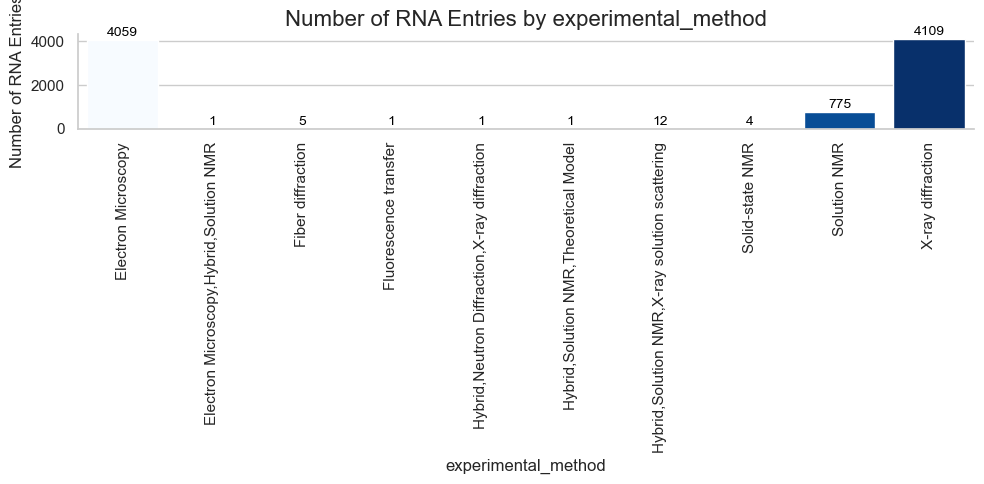

In [19]:
df_yearly_counts = df_results.groupby('experimental_method').size().reset_index(name='count')

df_yearly_counts = df_yearly_counts.sort_values(by='experimental_method', ascending=True)

#display_table(df_results, top_n=20)

# Convert 'experimental_method' to categorical codes
df_yearly_counts['experimental_method_code'] = pd.Categorical(df_yearly_counts['experimental_method']).codes

norm = plt.Normalize(df_yearly_counts['experimental_method_code'].min(), df_yearly_counts['experimental_method_code'].max())
cmap = cm.Blues

df_yearly_counts['color'] = [cmap(norm(code)) for code in df_yearly_counts['experimental_method_code']]

plt.figure(figsize=(10, 5))
ax = sns.barplot(x='experimental_method', y='count', data=df_yearly_counts, palette=df_yearly_counts['color'])

for i, p in enumerate(ax.patches):
    p.set_facecolor(df_yearly_counts['color'].iloc[i])

plt.xlabel('experimental_method', fontsize=12)
plt.ylabel('Number of RNA Entries', fontsize=12)
plt.title('Number of RNA Entries by experimental_method', fontsize=16)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')

plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
sns.despine()  # Remove top and right axes for cleaner view
plt.tight_layout()
plt.show()


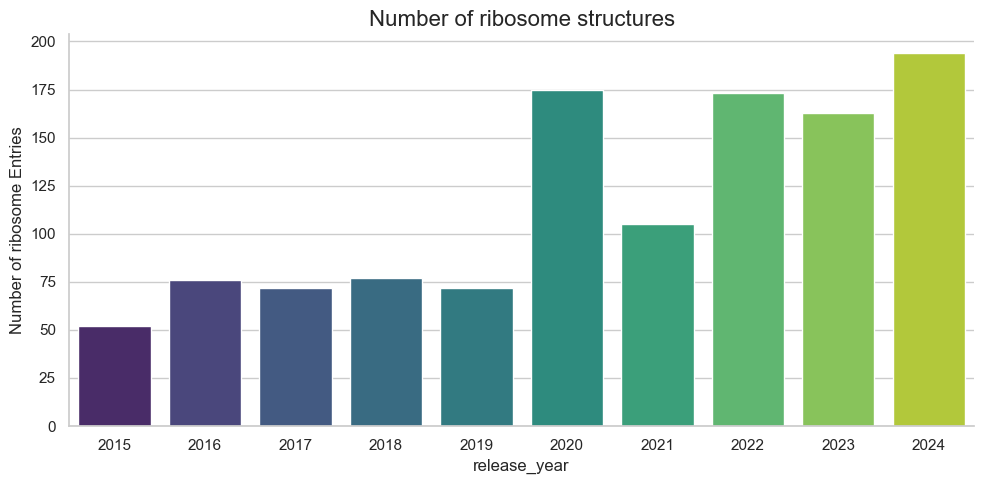

In [21]:
ribosome_count = df_results['title'].str.contains("ribosome", case=False, na=False).sum()
#print(f"Number of entries where title contains 'ribosome': {ribosome_count}")

# Filter ribosome entries (case-insensitive)
df_ribosome = df_results[df_results['title'].str.contains("ribosome", case=False, na=False)]

#Ensure release_year is numeric
df_ribosome = df_ribosome.copy()
df_ribosome.loc[:, 'release_year'] = pd.to_numeric(df_ribosome['release_year'], errors='coerce')

# Group by release year and count entries
ribosome_per_year = df_ribosome.groupby('release_year')['pdb_id'].count().reset_index()


#Filter for years between 2014 and 2024
ribosome_per_year = ribosome_per_year[
    (ribosome_per_year['release_year'] > 2014) & 
    (ribosome_per_year['release_year'] <= 2024)
]


#df_yearly_counts = df_results.groupby('assembly_composition').size().reset_index(name='count')

#df_yearly_counts = df_yearly_counts.sort_values(by='assembly_composition', ascending=True)

#display_table(df_results, top_n=20)

# Convert 'assembly_composition' to categorical codes
#df_yearly_counts['assembly_composition_code'] = pd.Categorical(df_yearly_counts['assembly_composition']).codes

#norm = plt.Normalize(df_yearly_counts['assembly_composition_code'].min(), df_yearly_counts['assembly_composition_code'].max())
#cmap = cm.Blues

#df_yearly_counts['color'] = [cmap(norm(code)) for code in df_yearly_counts['assembly_composition_code']]

plt.figure(figsize=(10, 5))
ax = sns.barplot(x='release_year', y='pdb_id', data=ribosome_per_year, palette='viridis')

#for i, p in enumerate(ax.patches):
 #   p.set_facecolor(df_yearly_counts['color'].iloc[i])

plt.xlabel('release_year', fontsize=12)
plt.ylabel('Number of ribosome Entries', fontsize=12)
plt.title('Number of ribosome structures', fontsize=16)

#for p in ax.patches:
    #ax.annotate(f'{int(p.get_height())}', 
    #            (p.get_x() + p.get_width() / 2., p.get_height()), 
    #            ha='center', va='center', fontsize=10, color='black', 
    #           xytext=(0, 5), textcoords='offset points')

plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
sns.despine()  # Remove top and right axes for cleaner view
plt.tight_layout()
plt.show()

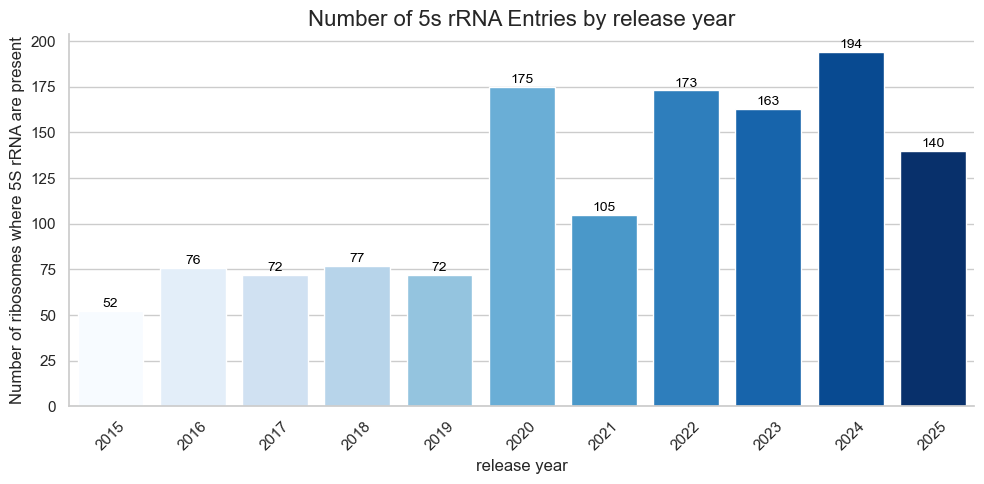

In [23]:
df_results = df_results[df_results['title'].str.contains('ribosome', case=False, na=False)]

#display_table(df_results, top_n=20)

df_results.to_csv('RNA_all.csv', index=False)

df_filtered = df_results[(df_results['release_year'] >= 2015) & (df_results['release_year'] <= 2025)]

df_yearly_counts = df_filtered.groupby('release_year').size().reset_index(name='count')

df_yearly_counts = df_yearly_counts.sort_values(by='release_year', ascending=True)

#df_yearly_counts['assembly_composition_code'] = pd.Categorical(df_yearly_counts['assembly_composition']).codes

norm = plt.Normalize(df_yearly_counts['release_year'].min(), df_yearly_counts['release_year'].max())
cmap = cm.Blues

df_yearly_counts['color'] = [cmap(norm(code)) for code in df_yearly_counts['release_year']]

plt.figure(figsize=(10, 5))
ax = sns.barplot(x='release_year', y='count', data=df_yearly_counts, palette='viridis')

for i, p in enumerate(ax.patches):
    p.set_facecolor(df_yearly_counts['color'].iloc[i])

plt.xlabel('release year', fontsize=12)
plt.ylabel('Number of ribosomes where 5S rRNA are present', fontsize=12)
plt.title('Number of 5s rRNA Entries by release year', fontsize=16)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
sns.despine()  # Remove top and right axes for cleaner view
plt.tight_layout()
plt.show()



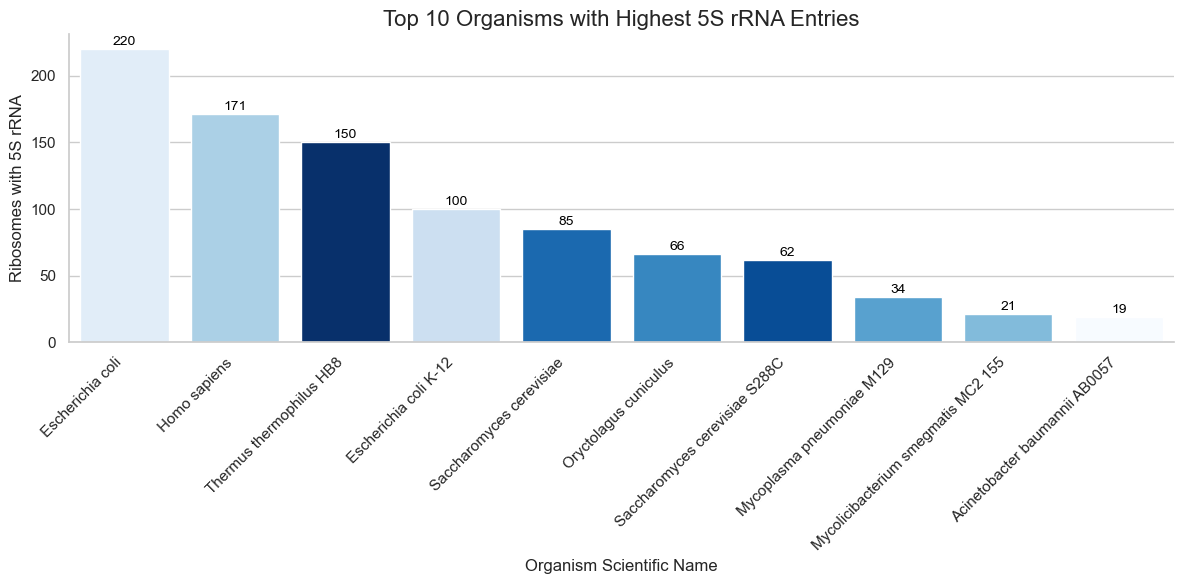

In [25]:
df_results = df_results[df_results['title'].str.contains('ribosome', case=False, na=False)]

#display_table(df_results, top_n=20)

df_results.to_csv('RNA_all.csv', index=False)

df_filtered = df_results[(df_results['release_year'] >= 2015) & (df_results['release_year'] <= 2025)]

df_yearly_counts = df_filtered.groupby('organism_scientific_name').size().reset_index(name='count')

df_yearly_counts = df_yearly_counts.sort_values(by='organism_scientific_name', ascending=True)

df_yearly_counts['organism_code'] = pd.Categorical(df_yearly_counts['organism_scientific_name']).codes

# Get the top 10 organisms with the highest count
df_top10 = df_yearly_counts.sort_values(by='count', ascending=False).head(10)

# Recalculate color mapping for just the top 10
df_top10['organism_code'] = pd.Categorical(df_top10['organism_scientific_name']).codes
norm = plt.Normalize(df_top10['organism_code'].min(), df_top10['organism_code'].max())
cmap = cm.Blues
df_top10['color'] = [cmap(norm(code)) for code in df_top10['organism_code']]

# Create the plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='organism_scientific_name', y='count', data=df_top10, palette='viridis')

# Apply colors
for i, p in enumerate(ax.patches):
    p.set_facecolor(df_top10['color'].iloc[i])

# Label the axes and title
plt.xlabel('Organism Scientific Name', fontsize=12)
plt.ylabel('Ribosomes with 5S rRNA', fontsize=12)
plt.title('Top 10 Organisms with Highest 5S rRNA Entries', fontsize=16)

# Annotate bars with count values
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')

# Improve x-axis readability
plt.xticks(rotation=45, ha='right')  
sns.despine()
plt.tight_layout()
plt.show()


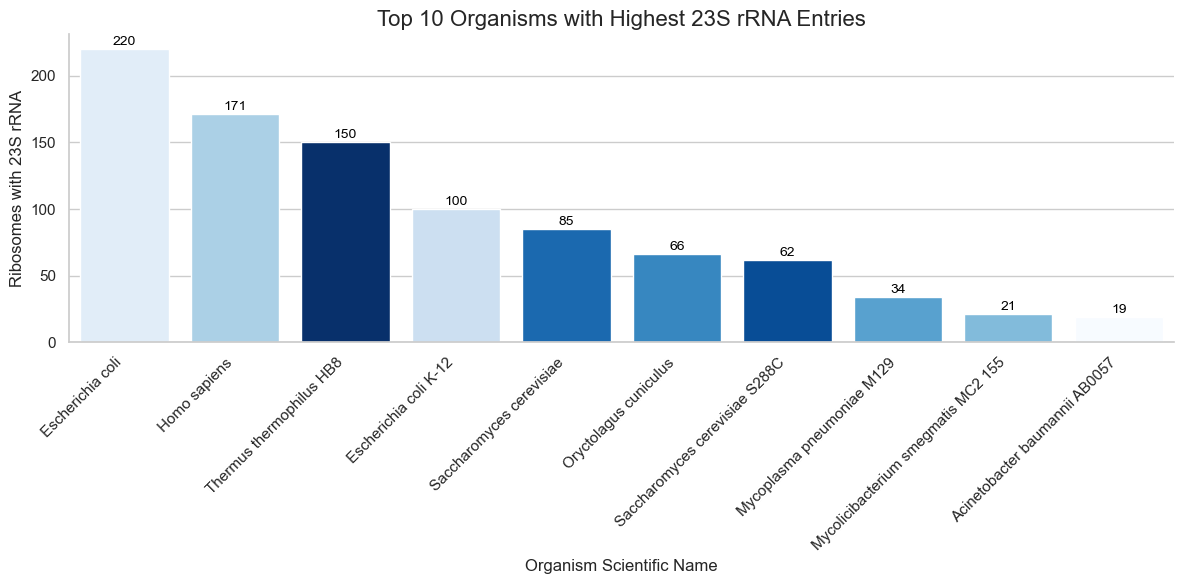

In [27]:
df_results = df_results[df_results['title'].str.contains('ribosome', case=False, na=False)]

#display_table(df_results, top_n=20)

df_results.to_csv('RNA_all.csv', index=False)

df_filtered = df_results[(df_results['release_year'] >= 2015) & (df_results['release_year'] <= 2025)]

df_yearly_counts = df_filtered.groupby('organism_scientific_name').size().reset_index(name='count')

df_yearly_counts = df_yearly_counts.sort_values(by='organism_scientific_name', ascending=True)

df_yearly_counts['organism_code'] = pd.Categorical(df_yearly_counts['organism_scientific_name']).codes

# Get the top 10 organisms with the highest count
df_top10 = df_yearly_counts.sort_values(by='count', ascending=False).head(10)

# Recalculate color mapping for just the top 10
df_top10['organism_code'] = pd.Categorical(df_top10['organism_scientific_name']).codes
norm = plt.Normalize(df_top10['organism_code'].min(), df_top10['organism_code'].max())
cmap = cm.Blues
df_top10['color'] = [cmap(norm(code)) for code in df_top10['organism_code']]

# Create the plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='organism_scientific_name', y='count', data=df_top10, palette='viridis')

# Apply colors
for i, p in enumerate(ax.patches):
    p.set_facecolor(df_top10['color'].iloc[i])

# Label the axes and title
plt.xlabel('Organism Scientific Name', fontsize=12)
plt.ylabel('Ribosomes with 23S rRNA', fontsize=12)
plt.title('Top 10 Organisms with Highest 23S rRNA Entries', fontsize=16)

# Annotate bars with count values
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')

# Improve x-axis readability
plt.xticks(rotation=45, ha='right')  
sns.despine()
plt.tight_layout()
plt.show()


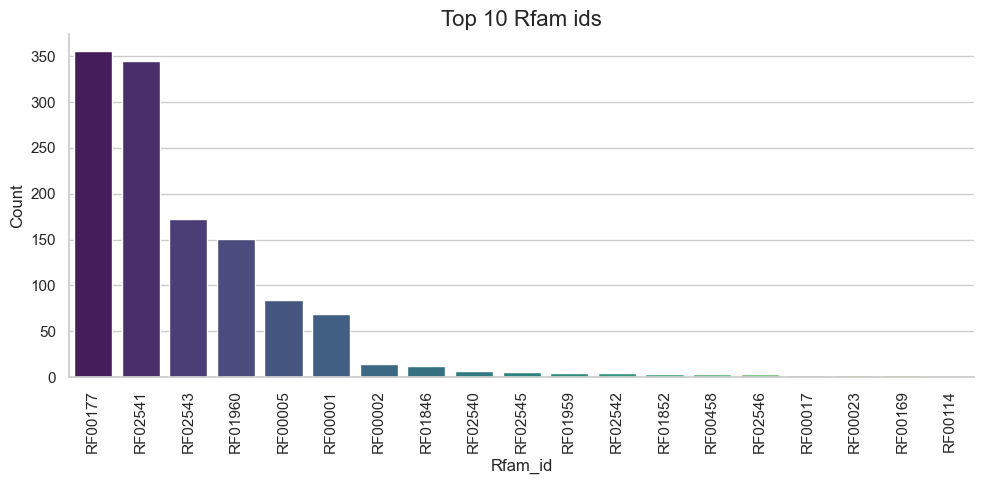

In [29]:
df_results = df_results.dropna(subset=['rfam'])



# Split the 'rfam' column into two new columns
df_results[['rfam_id', 'rfam_name']] = df_results['rfam'].str.split(':', n=1, expand=True)

# strip extra whitespace
df_results['rfam_id'] = df_results['rfam_id'].str.strip()
df_results['rfam_name'] = df_results['rfam_name'].str.strip()

#display_table(df_results, top_n=20)

df_results['release_year'] = pd.to_numeric(df_results['release_year'], errors='coerce')

# Filter for years 2014 to 2024
df_filtered = df_results[(df_results['release_year'] >= 2014) & (df_results['release_year'] <= 2024)]

# Drop NaNs in rfam_id (optional but recommended)
df_filtered = df_filtered.dropna(subset=['rfam_id'])

# Count rfam_id occurrences
rfam_counts = df_filtered['rfam_id'].value_counts()

# Get top 10 Rfam IDs by count
top_rfam_counts = rfam_counts.head(20).reset_index()
top_rfam_counts.columns = ['rfam_id', 'count']

plt.figure(figsize=(10, 5))
ax = sns.barplot(x='rfam_id', y='count', data=top_rfam_counts, palette='viridis')

#for i, p in enumerate(ax.patches):
 #   p.set_facecolor(df_yearly_counts['color'].iloc[i])

plt.xlabel('Rfam_id', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Top 10 Rfam ids', fontsize=16)

#for p in ax.patches:
    #ax.annotate(f'{int(p.get_height())}', 
    #            (p.get_x() + p.get_width() / 2., p.get_height()), 
    #            ha='center', va='center', fontsize=10, color='black', 
    #           xytext=(0, 5), textcoords='offset points')

plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
sns.despine()  # Remove top and right axes for cleaner view
plt.tight_layout()
plt.show()


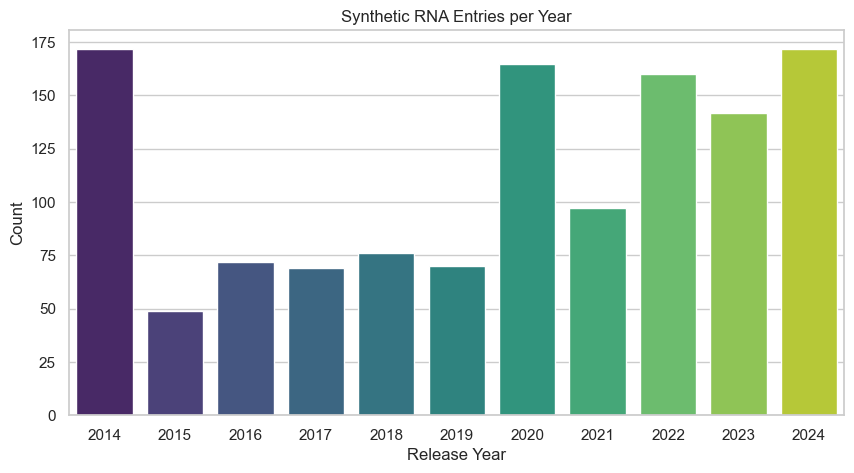

In [31]:
df_results = df_results.dropna(subset=['release_year'])

# Convert year to numeric
df_results['release_year'] = pd.to_numeric(df_results['release_year'], errors='coerce')

# Filter by year
df_recent = df_results[(df_results['release_year'] >= 2014) & (df_results['release_year'] <= 2024)]

# Count per year
yearly_counts = df_recent.groupby('release_year').size().reset_index(name='count')

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=yearly_counts, x='release_year', y='count', palette='viridis')
# Annotate bars with count values
for index, row in yearly_counts.iterrows():
    ax.text(index, row['count'] + 1, f"{row['count']}", color='black', ha="center")

plt.title("Synthetic RNA Entries per Year")
plt.ylabel("Count")
plt.xlabel("Release Year")
plt.show()


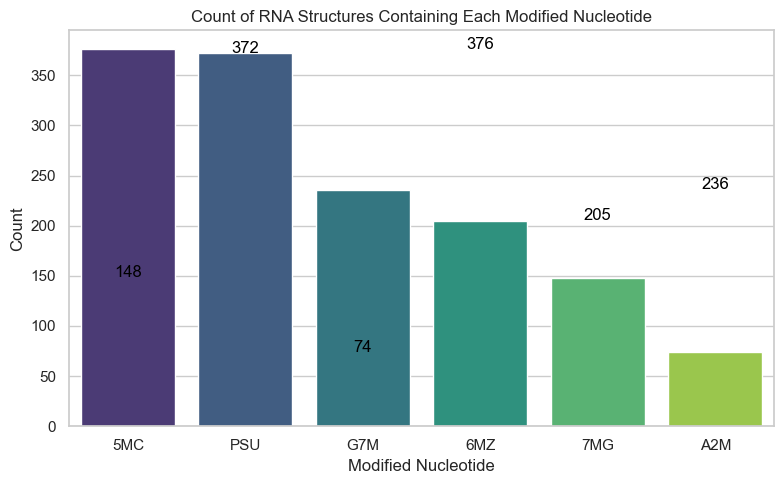

In [33]:
df_results = df_results.dropna(subset=['interacting_ligands'])

#df_results.head(20)

# Define your list of modifications
modifications = ['7MG', "PSU", "A2M", "5MC", "6MZ", 'G7M']

# Create a regex pattern
pattern = "|".join(modifications)

# Filter entries that contain any of the modifications
df_mods = df_results[df_results['compound_name'].str.contains(pattern, na=False)]

# Count how many entries mention each modification
mod_counts = {}
for mod in modifications:
    mod_counts[mod] = df_mods['compound_name'].str.contains(mod, na=False).sum()

# Convert to DataFrame for plotting
df_mod_counts = pd.DataFrame(list(mod_counts.items()), columns=["modification", "count"])

# Sort by count descending (optional)
df_mod_counts = df_mod_counts.sort_values(by="count", ascending=False)

# Plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=df_mod_counts, x="modification", y="count", palette="viridis")

# Add count labels on top
for index, row in df_mod_counts.iterrows():
    ax.text(index, row['count'] + 0.5, f"{row['count']}", color='black', ha="center")

plt.title("Count of RNA Structures Containing Each Modified Nucleotide")
plt.ylabel("Count")
plt.xlabel("Modified Nucleotide")
plt.tight_layout()
plt.show()


15     5MC
24     OMG
17     5MU
26     UR3
41     OMC
      ... 
88     MGP
305    2IA
302    N5M
301    N5C
231    ZBC
Name: short_label, Length: 141, dtype: object


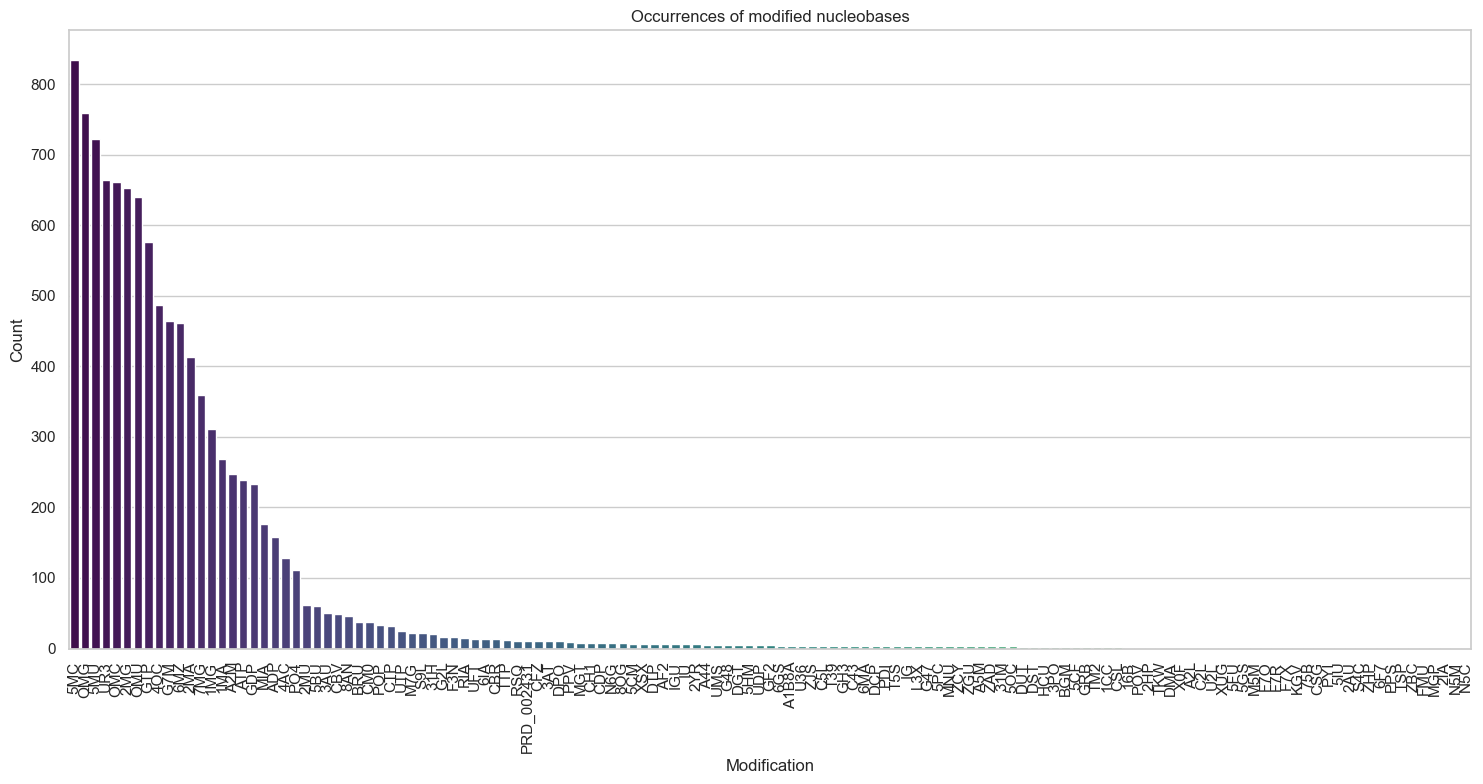

In [37]:
# Drop NaNs
compound_series = df_results['compound_name'].dropna()


# Initialize a counter to store occurrences of 'ribo'-containing terms
ribo_counter = collections.Counter()

# Split strings and count terms containing 'ribo'
for entry in compound_series:
    terms = [term.strip() for term in entry.split(',')]
    for term in terms:
        if 'phosphate' in term.lower():  # case-insensitive match
            ribo_counter[term] += 1

# Convert counter to DataFrame
df_ribo_mods = pd.DataFrame(ribo_counter.items(), columns=['modification', 'count'])

# Sort by count
df_ribo_mods = df_ribo_mods.sort_values(by='count', ascending=False)



# Keep only modifications that contain a colon
df_ribo_mods = df_ribo_mods[df_ribo_mods['modification'].str.contains(":", na=False)]


# Create a short label column (first part before ":" if exists)
df_ribo_mods['short_label'] = df_ribo_mods['modification'].apply(lambda x: x.split(':')[0].strip())
print(df_ribo_mods['short_label'])

# Plot
plt.figure(figsize=(15, 8))
sns.barplot(data=df_ribo_mods, x='short_label', y='count', palette='viridis')



plt.title("Occurrences of modified nucleobases")
plt.xticks(rotation=90, ha='center')
plt.xlabel("Modification")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


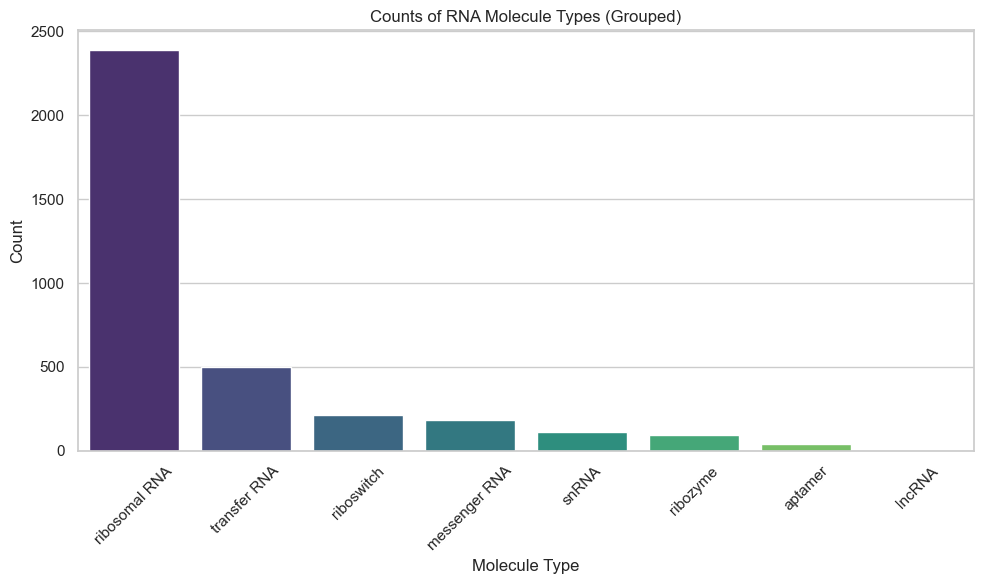

In [44]:
# Drop NaNs and make lowercase
if 'molecule_name' in df_results.columns:
    molecule_series = df_results['molecule_name'].dropna().str.lower()

# Mapping keywords to desired categories
category_map = {
    'rrna': 'ribosomal RNA',
    'ribosomal rna': 'ribosomal RNA',
    'trna': 'transfer RNA',
    'transfer rna': 'transfer RNA',
    'mrna': 'messenger RNA',
    'messenger rna': 'messenger RNA',
    'ribozyme': 'ribozyme',
    'riboswitch': 'riboswitch',
    'RNA quadruplex': 'quadruplex',
    'aptamer': 'aptamer',
    'snrna': 'snRNA',
    'lncrna': 'lncRNA',
    'crrna': 'crRNA'
}



# Initialize Counter
from collections import Counter
category_counts = Counter()

# Loop through entries and count based on category_map
for entry in molecule_series:
    for keyword, category in category_map.items():
        if keyword in entry:
            category_counts[category] += 1
            break  # Only count once per entry

# Convert to DataFrame
category_df = pd.DataFrame.from_dict(category_counts, orient='index', columns=['count']).reset_index()
category_df.columns = ['molecule_type', 'count']
category_df = category_df.sort_values(by='count', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=category_df, x='molecule_type', y='count', palette='viridis')
plt.title('Counts of RNA Molecule Types (Grouped)')
plt.xlabel('Molecule Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

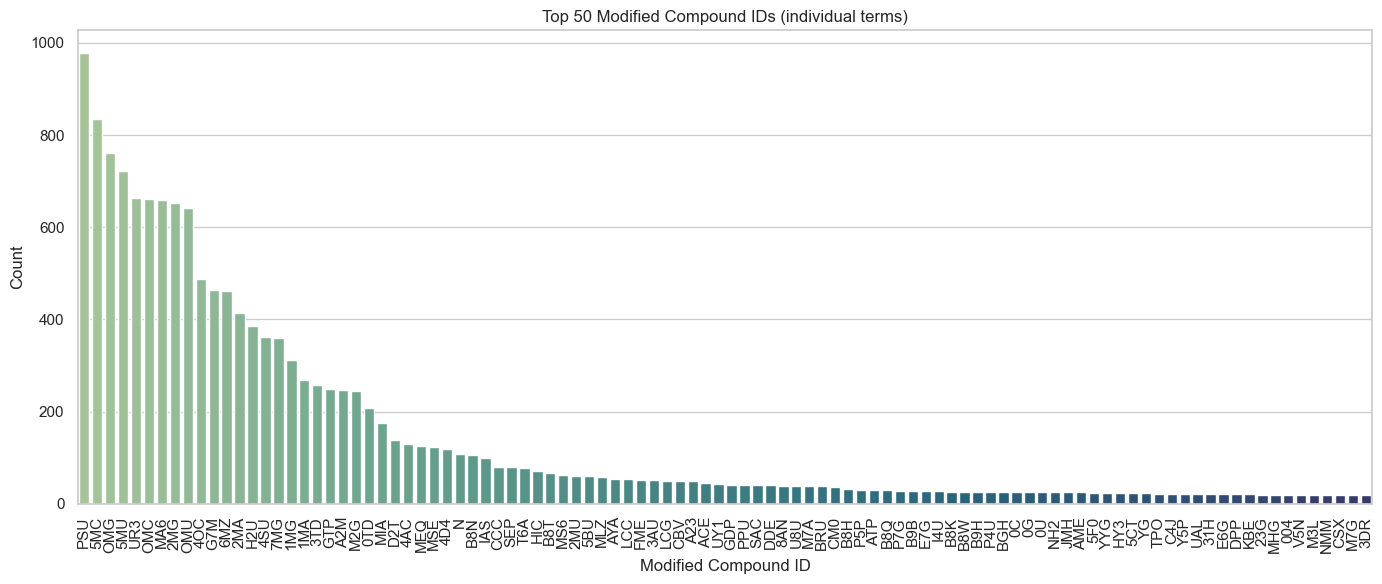

In [46]:
# Drop NaNs
compound_series = df_results['modified_compound_id'].dropna()

# Split comma-separated values and flatten the list
all_mods = compound_series.str.split(',').explode().str.strip()

# Count unique values
mod_counts = all_mods.value_counts()

# Get top 50
top_50 = mod_counts.head(100).reset_index()
top_50.columns = ['modification', 'count']

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=top_50, x='modification', y='count', palette='crest')
plt.xticks(rotation=90)
plt.title('Top 50 Modified Compound IDs (individual terms)')
plt.xlabel('Modified Compound ID')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

**Summary**

- RNA structures are increasing in the PDB over time.  

- The majority are solved by specific experimental methods (e.g., X-ray, cryo-EM).  

- Resolutions vary but cluster around certain ranges.  

These tools can be adapted for other macromolecule queries (DNA, proteins, ligands).